In [4]:
import numpy as np
import torch
import torchvision

import torchvision.transforms as transforms
from datasets import SynthDataset
from synth_utils import js_div, kl_div, pca
from priors import FactorizedNormalPrior
import torch.nn.functional as F

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/local/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Dataset

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          shuffle=True, num_workers=2)

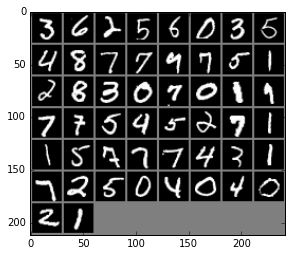

In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## BGAN-NG

In [7]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [8]:
trainset[0][0].size()

torch.Size([1, 28, 28])

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)

class GeneratorNetwork(nn.Module):
    
    def __init__(self, shape, num_samples, init=None):
        super(GeneratorNetwork, self).__init__()
        self.build_net(shape, num_samples, init)
        self.output_dim = shape
    
    def build_net(self, shape, num_samples, init):
        if init is None:
            z = torch.from_numpy(np.random.normal(size=[num_samples] + shape)).float()
        else:
            z = torch.from_numpy(init).float()
        self.z_v = Variable(z, requires_grad=True)
    
    
    def forward(self):
        output = self.z_v
        return output
    
    def parameters(self):
        return [self.z_v]

class DiscriminatorNetwork(nn.Module):
    
    def __init__(self, K):
        super(DiscriminatorNetwork, self).__init__()
        self.build_net(K)
        self.K = K
    
    def build_net(self, K):
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x)

    
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [10]:
class FixedSizeDataset(torch.utils.data.Dataset):
    
    def __init__(self, maxlen):
        self.elems = []
        self.maxlen = maxlen
        
    def __getitem__(self, index):
        return self.elems[index]
    
    def append(self, elem):
        self.elems.append(elem)
        if len(self) > self.maxlen:
            self.elems = self.elems[1:]
    
    def __len__(self):
        return len(self.elems)

In [11]:
from bgan_nogen import BGANNG

In [12]:
batch_size = 50
z_init = np.copy(trainset[123][0].numpy())[None, :]

In [13]:
prior = FactorizedNormalPrior(std=5.)
disc = DiscriminatorNetwork(2)
gen = GeneratorNetwork([1, 28, 28], 1, init=z_init)
bgan = BGANNG(gen, prior, disc, alpha=.01, eta=1e-3, num_data=len(trainset), disc_lr=1e-5, cuda=True)
# gen.apply(weights_init)
# disc.apply(weights_init)
samples = []

Moving generator and discriminator to GPU


In [564]:
#gen = GeneratorNetwork([1, 28, 28], 1, init=z_init)
gen.forward()

Variable containing:
(0 ,0 ,.,.) = 

Columns 0 to 8 
  -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000
 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000
 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000
 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000
 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000
 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000
 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000
 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000
 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000
 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -0.5529 -0.3333
 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -0.4745  0.5451  0.8353  0.9765
 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -0.3333  0.9765  0.9765  0.9765
 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -0.7020  0.7333  0.2314 -0.12

In [700]:
old_samples = None
if isinstance(samples, np.ndarray):
    old_samples = np.copy(samples)
    samples = []
for epoch in range(100):
    for i, data_ in enumerate(trainloader, 0):

        batch = data_[0].float()
        bgan.step(batch)
        if not i%100:
#             print(i)
            bgan.fake_dataset.append(np.copy(gen.z_v.data.numpy()[0, :]))
    if not epoch%1:
        samples.append(np.copy(gen.z_v.data.numpy()))
    if not epoch%1:
        print(epoch)
        print(bgan.d_loss_fake)
        print(bgan.d_loss_real)
if old_samples is not None:
    samples = np.vstack([old_samples, np.array(samples)])
else:
    samples = np.array(samples)

0
0.0766624
0.25499
1
0.0951452
0.096999
2
0.109334
0.0951781
3
0.107481
0.344562
4
0.256995
0.180771
5
0.131427
0.083639
6
0.104856
0.0961253
7
0.112584
0.0659473
8
0.197596
0.0918101
9
0.0778548
0.0964367
10
0.0488805
0.0822991
11
0.105716
0.132868
12
0.195235
0.14154
13
0.0951968
0.125414
14
0.167915
0.147557
15
0.213478
0.128393
16
0.128855
0.158151
17
0.0962179
0.144095
18
0.179292
0.0801275
19
0.0692756
0.0883971
20
0.187283
0.297525
21
0.0682664
0.116064
22
0.353537
0.0892802
23
0.132295
0.170966
24
0.197278
0.0788125
25
0.121188
0.0797051
26
0.208145
0.0560497
27
0.157459
0.0698052
28
0.136464
0.120868
29
0.106934
0.137251
30
0.135777
0.0685645
31
0.0949142
0.0778345
32
0.123438
0.269576
33
0.122604
0.113263
34
0.138712
0.117832
35
0.186471
0.107751
36
0.278781
0.190746
37
0.0690784
0.142375
38
0.133825
0.16331
39
0.086648
0.171207
40
0.105524
0.127567
41
0.105458
0.141593
42
0.152471
0.103617
43
0.222109
0.0968355
44
0.150186
0.0792731
45
0.158672
0.0953726
46
0.177626
0.08364

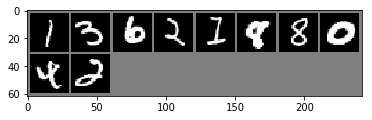

In [701]:
imshow(torchvision.utils.make_grid(batch[:10]))

In [702]:
fake_samples = []
for sample in bgan.fake_dataset:
    fake_samples.append(sample)
fake_samples = np.array(fake_samples)

In [703]:
samples = [np.array(sample).reshape((1, 1, 28, 28)) for sample in samples]

In [704]:
samples_arr = np.vstack(samples)

In [705]:
samples_arr.shape

(3042, 1, 28, 28)

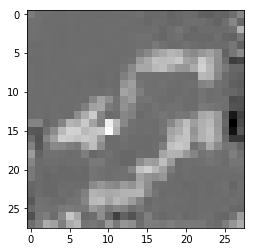

In [706]:
plt.imshow((samples_arr[-1, 0] + 1)/2, cmap='gray')

In [707]:
np.max(batch.numpy())

1.0

In [708]:
samples_arr.shape

(3042, 1, 28, 28)

In [709]:
samples_arr[samples_arr < - 1] = -1
samples_arr[samples_arr > 1] = 1

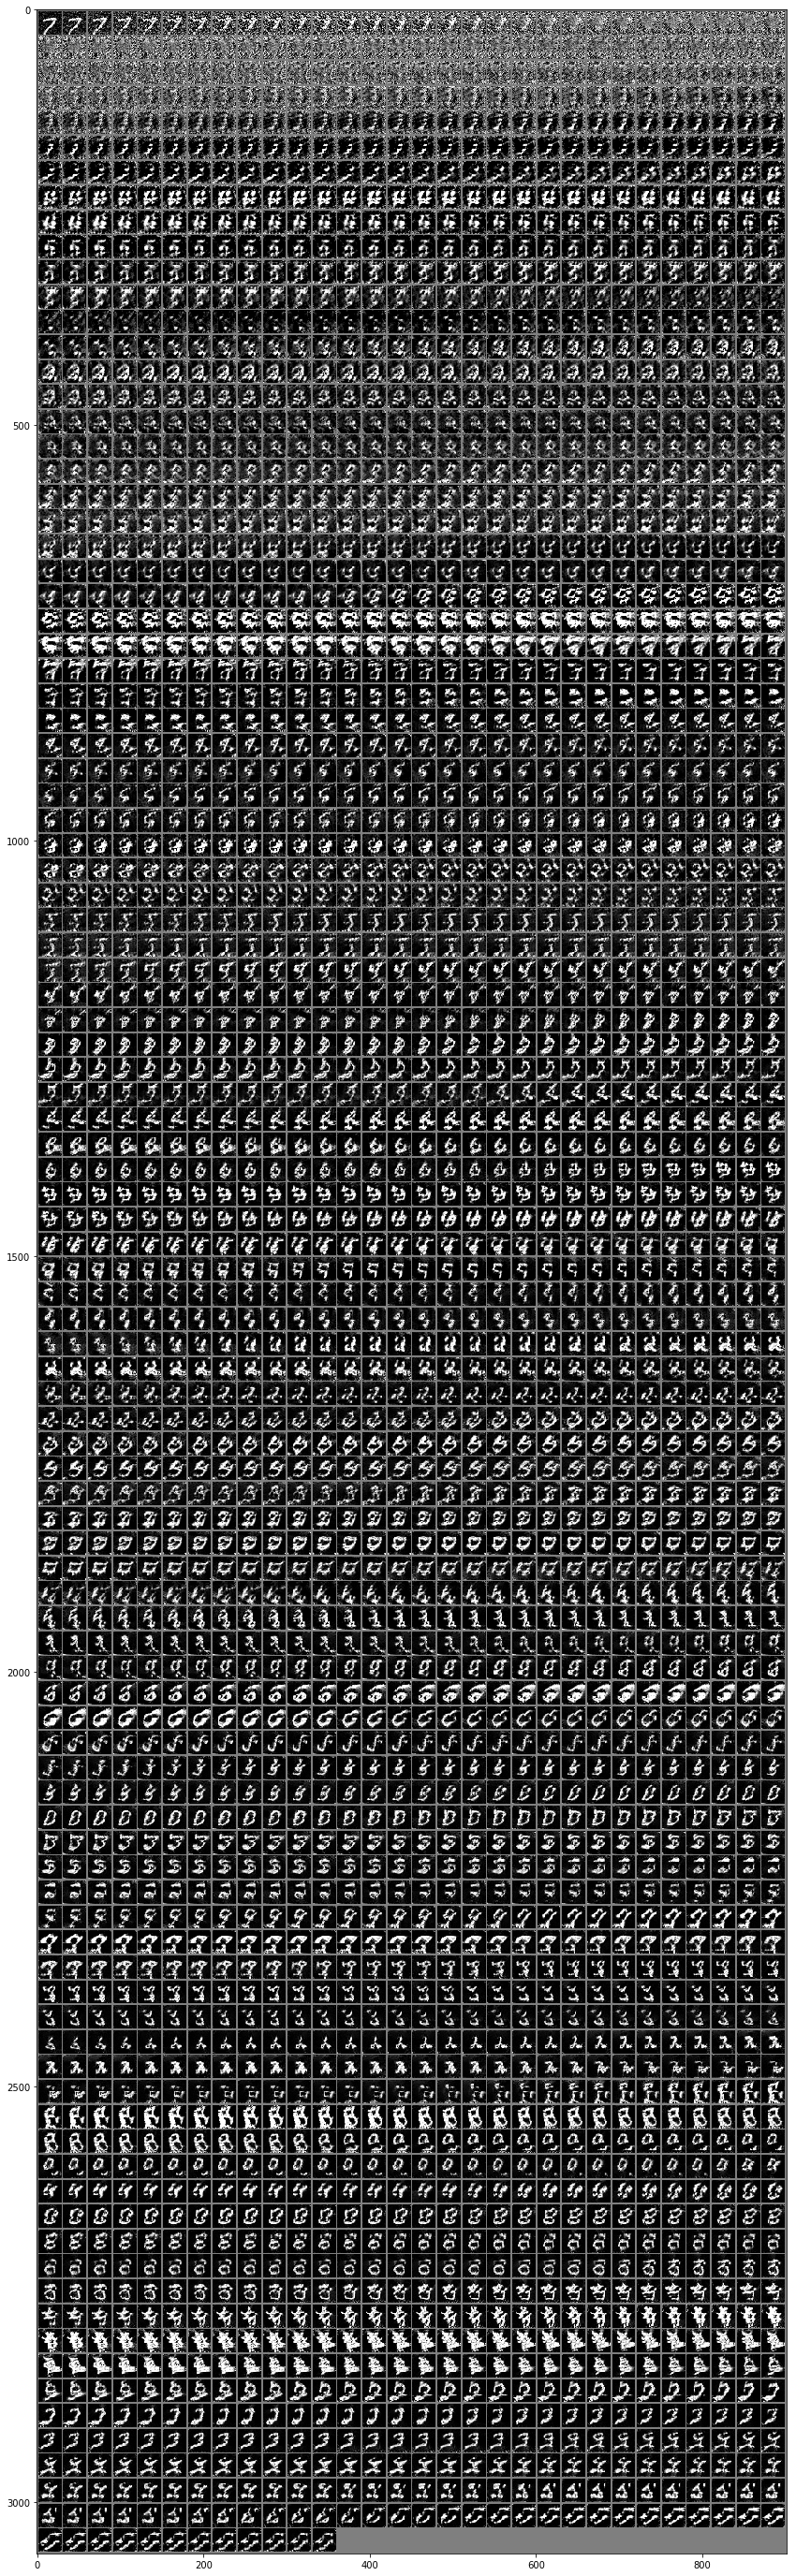

In [711]:
plt.figure(figsize=(20, 50))
imshow(torchvision.utils.make_grid(torch.from_numpy(samples_arr[:]), nrow=30))


In [675]:
sample_probs = bgan.discriminator(Variable(torch.from_numpy(samples_arr[-100:]).float()).cuda())[:, 0]

In [676]:
sample_probs

Variable containing:
 0.7485
 0.7704
 0.7569
 0.6473
 0.8342
 0.6627
 0.8117
 0.7938
 0.6807
 0.7110
 0.6903
 0.7226
 0.8014
 0.6831
 0.7772
 0.8616
 0.8307
 0.7458
 0.7753
 0.8589
 0.8388
 0.7404
 0.8264
 0.8411
 0.7829
 0.8383
 0.8324
 0.7904
 0.8684
 0.8357
 0.8445
 0.8165
 0.8179
 0.7921
 0.7193
 0.8361
 0.8302
 0.8666
 0.7999
 0.8240
 0.7699
 0.8135
 0.8035
 0.8570
 0.8836
 0.8639
 0.8098
 0.8612
 0.8107
 0.8431
 0.8023
 0.8840
 0.8386
 0.8875
 0.8985
 0.8661
 0.8427
 0.8913
 0.8406
 0.7751
 0.8792
 0.7851
 0.8806
 0.7856
 0.9126
 0.8588
 0.8059
 0.8232
 0.8213
 0.7779
 0.8160
 0.8396
 0.8653
 0.8418
 0.8574
 0.8800
 0.8665
 0.8983
 0.8881
 0.8902
 0.8438
 0.8018
 0.7894
 0.8795
 0.8914
 0.8428
 0.8187
 0.8946
 0.8021
 0.8338
 0.8171
 0.8640
 0.8746
 0.7876
 0.8423
 0.8562
 0.8346
 0.8559
 0.8738
 0.8135
[torch.cuda.FloatTensor of size 100 (GPU 0)]

In [679]:
disc(Variable(batch).cuda())[:, 0]

Variable containing:
 0.7235
 0.7993
 0.7501
 0.8424
 0.4019
 0.8174
 0.7988
 0.8607
 0.8839
 0.7365
 0.8428
 0.8265
 0.6104
 0.7270
 0.7838
 0.8431
 0.8651
 0.8589
 0.7899
 0.8175
 0.7914
 0.8455
 0.7148
 0.7867
 0.5143
 0.7957
 0.8807
 0.7820
 0.7927
 0.7861
 0.7605
 0.7809
 0.7754
 0.8324
 0.8999
 0.8361
 0.7216
 0.8109
 0.8405
 0.8527
 0.8221
 0.8806
 0.7403
 0.7628
 0.8398
 0.7767
 0.6398
 0.7129
 0.8650
 0.7762
[torch.cuda.FloatTensor of size 50 (GPU 0)]

In [60]:
idx = np.where(sample_probs > 0.5)
good_samples = samples[idx]

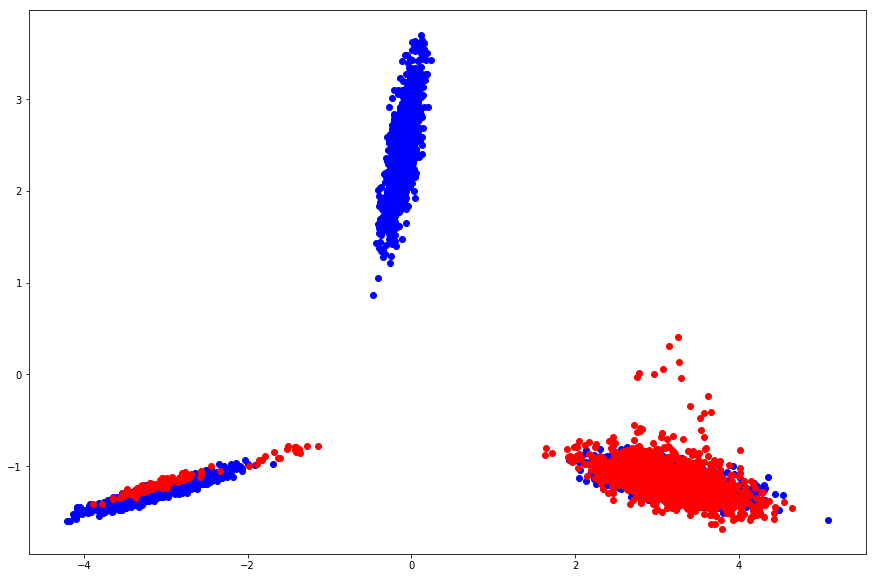

In [61]:
plt.figure(figsize=(15, 10))
x_r, x_f = pca(data.X.numpy(), good_samples)
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(x_f[:, 0], x_f[:, 1], 'ro')
# plt.plot(x_f[-1, 0], x_f[-1, 1], 'ro', markersize=10)

In [62]:
true_probs = disc(Variable(data.X))[:, 0].data.numpy()
np.min(true_probs)

0.29538473

In [63]:
bad_idx = np.where(true_probs < 0.5)
bad_data = data.X.numpy()[bad_idx]

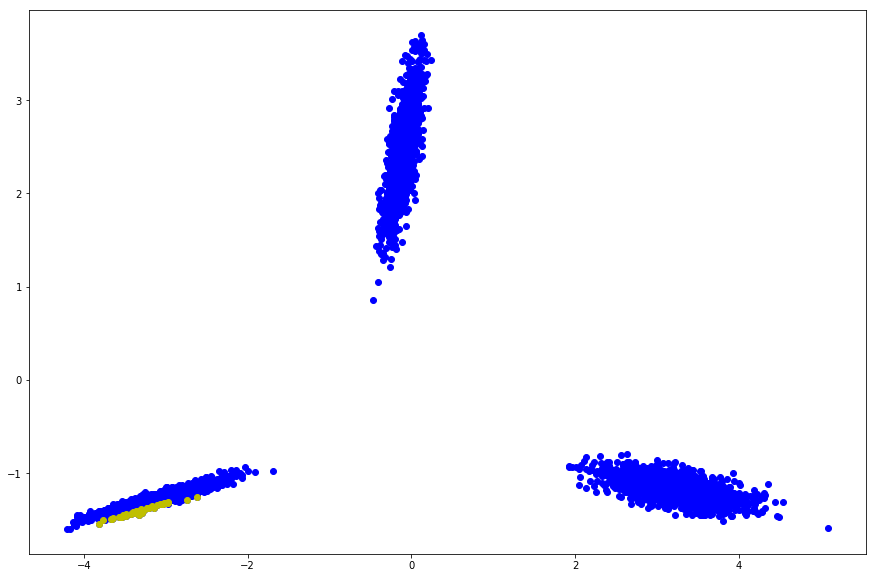

In [64]:
plt.figure(figsize=(15, 10))
x_r, x_b = pca(data.X.numpy(), bad_data)
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(x_b[:, 0], x_b[:, 1], 'yo')